In [18]:
import sys
import random
import os
import zipfile
import matplotlib
import datetime
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pathlib import Path


In [19]:
# 한글 폰트 설정
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False


In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed=3407
seed_everything(seed)


In [26]:
ROOT_PATH = Path("C:/Users/82106/Desktop/데이터분석 프로젝트/서울시 평균 기온 예측/data")
DATA_PATH = ROOT_PATH / "data"
os.makedirs(DATA_PATH, exist_ok=True)

SAVE_PATH = DATA_PATH / "submit"
os.makedirs(SAVE_PATH, exist_ok=True)

if not os.path.exists(DATA_PATH / "train.csv"):
  with zipfile.ZipFile(ROOT_PATH / "open.zip", 'r') as f:
    f.extractall(DATA_PATH)


In [27]:
raw_train = pd.read_csv(DATA_PATH / 'train.csv')


In [28]:
# 데이터는 2000년부터 사용
df = raw_train.loc[raw_train['일시'] >= '2000-01-01']
df.reset_index(drop=True, inplace=True)


In [29]:
date_time = pd.to_datetime(df.pop('일시'), format='%Y-%m-%d')


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


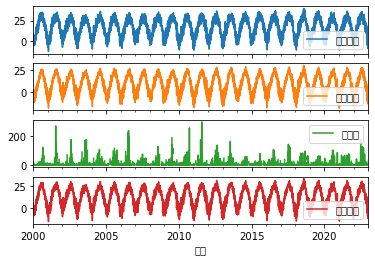

In [30]:
plot_cols = ['최고기온', '최저기온', '강수량', '평균기온']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


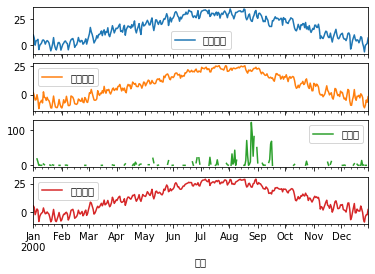

In [31]:
plot_features = df[plot_cols][:365]
plot_features.index = date_time[:365]
_ = plot_features.plot(subplots=True)


In [32]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
최고기온,8400.0,17.550119,10.700869,-12.4,8.40,19.40,26.900,39.60
최저기온,8400.0,9.095274,10.624205,-18.6,0.30,9.90,18.625,30.30
일교차,8399.0,8.453518,2.854957,1.1,6.50,8.40,10.400,18.50
강수량,3272.0,9.899725,23.041582,0.0,0.10,1.50,8.500,301.50
평균습도,8401.0,61.033722,14.880473,17.9,49.90,61.00,71.500,99.80
평균풍속,8398.0,2.343510,0.835757,0.3,1.80,2.20,2.800,7.50
일조합,8387.0,5.839883,3.924444,0.0,2.00,6.50,9.100,13.70
일사합,8373.0,12.590828,6.693488,0.0,7.54,11.71,17.400,31.11
일조율,8401.0,48.804273,32.735833,0.0,16.30,54.20,79.800,96.90
평균기온,8401.0,12.990263,10.513069,-15.5,4.10,14.30,22.400,33.70


In [33]:
null_cols = ['최고기온', '최저기온', '평균풍속', '일조합', '일사합']
for col in null_cols:
  df[col].interpolate(method='linear', inplace=True)


In [34]:
df['일교차'] = df['최고기온'] - df['최저기온']


In [35]:
df.loc[df['강수량'].isnull(), '강수량'] = 0.0


In [36]:
df.drop('일교차', axis=1, inplace=True)


In [37]:
# 날짜 데이터
date_data = pd.date_range(start='2000-01-01', end='2022-12-31', freq='D')

# 일 단위 추출
day_of_year = date_data.dayofyear

# 주기 함수로 변환
df['Day sin'] = np.sin(2 * np.pi * day_of_year / 365)
df['Day cos'] = np.cos(2 * np.pi * day_of_year / 365)


In [38]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):]


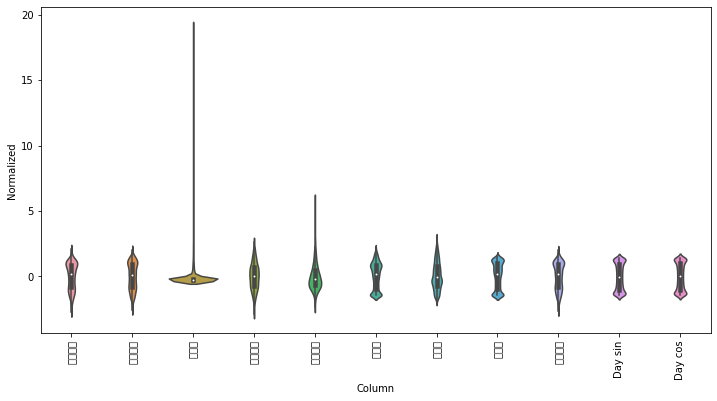

In [39]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


In [40]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


In [41]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [42]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.example = example


In [43]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [44]:
OUT_STEPS = 358
INPUT_WIDTH = OUT_STEPS * 3
multi_window = WindowGenerator(input_width=INPUT_WIDTH,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['평균기온'])


In [46]:
num_features = df.shape[1]

multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


In [48]:
input_for_submit = val_df[-INPUT_WIDTH:].values.reshape(1, INPUT_WIDTH, 11)

pred = multi_lstm_model.predict(input_for_submit)

prediction = pred[-1].reshape(-1,) * train_std['평균기온'] + train_mean['평균기온']


1/1 [==============================] - 6s 6s/step


In [50]:
prediction

array([12.737886, 12.737886, 12.737886, ..., 12.737886, 12.737886,
       12.737886], dtype=float32)